In [3]:
import os
path = 'data'
src_path = os.path.join(path, 'src')
label_path = os.path.join(path, 'label')

In [7]:
src_image = []        # src 이미지
label_image = []    # label 이미지
for i in os.listdir(src_path):
  src_image.append(os.path.join(src_path, i))

for i in os.listdir(label_path):
  label_image.append(os.path.join(label_path, i))


------------------------------------------

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import ntpath

In [19]:
def make_dir(path):
  try:
    os.mkdir(path)
  except Exception as e:
    print(e)
    pass

class Augment:
  COLOR_UNCHANGED = 0
  COLOR_GRAY = 1
  COLOR_BGR = 2
  def __init__(self, img, mask=None):
    """
    args:
      img : 지금은 image 경로. 추후에는 directory로 변경할 수 있음.
      mask : 지금은 label 경로. 추후에는 directory로 변경할 수 있음.
    instances:
      self.img_name : 입력된 image 파일 이름. (파일이름, 확장자명)으로 저장. 변환된 image 저장을 할 때 파일이름에 사용.
      self.mask_name : 입력된 label 파일 이름. (파일이름, 확장자명)으로 저장. 변환된 label 저장을 할 때 파일이름에 사용.
      self.img : OpenCV로 읽어온 image
      self.mask : OpenCV로 읽어온 label
      self.rows : image의 rows
       : image의 cols
      self.channels : image의 channels
      self.concat : image 혹은 image와 mask가 합쳐진 numpy array
      self.temp : 계속해서 변환되는 결과 값
    """
    self.img_name = ntpath.splitext(ntpath.basename(img))
    self.img = cv2.imread(img, cv2.IMREAD_UNCHANGED)
    if mask:
      self.mask_name = ntpath.splitext(ntpath.basename(mask))
      self.mask = cv2.imread(mask, cv2.IMREAD_UNCHANGED)
    else:
      self.mask_name = None
      self.mask = None

    # rows, cols 을 구함
    if self.img.ndim == 2:
        self.rows, self.cols = self.img.shape
        self.channels = 1
    elif self.img.ndim == 3:
        self.rows, self.cols, self.channels = self.img.shape
    else:
        print(f"Image's ndim must be 2 or 3. Your input image's ndim is {self.img.ndim}")
        self.rows = None
        self.cols = None
        self.channels = None
    self.concat = None
    self.temp = None

  def brightness(self, img, value=None):
    """
    밝기를 올리거나 줄임. value가 양수면 올리고 음수면 줄인다.
    args:
      img : OpenCV로 읽어온 이미지
      value : 밝기를 올리거나 줄일 값. (-255 ~ 255) [default=None]
    """
    if value:
      if value < -255 or value > 255:
        print('brightness_value must be -255 ~ 255')
      else:
        if value > 0:
          array = np.full(img.shape, value, dtype=np.uint8)
          self.img = cv2.add(img, array)
        else:
          value_ = abs(value)
          array = np.full(img.shape, value_, dtype=np.uint8)
          self.img = cv2.subtract(img, array)
  
  def clahe(self, img, clahe=False, contrast_limit=40, grid_size=(8,8)):
    """
    Histogram Equalization. CLAHE
    args:
      img : OpenCV로 읽어온 이미지
      clahe : boolean. clahe 사용 여부 [default=False]
      contrast_limit : clahe에서 사용할 clipLimit [default=40]
      grid_size : (m, n), clahe에서 사용할 tileGridSize [default=(8,8)]
    """
    if clahe:
      clahe_ = cv2.createCLAHE(clipLimit=contrast_limit, tileGridSize=grid_size)
      if self.channels == 1:
        self.img = clahe_.apply(img)
      elif self.channels == 3:
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        H, S, V = cv2.split(hsv_img)
        hsv_img[:,:,2] = clahe_.apply(V)
        self.img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
      elif self.channels == 4:
        B, G, R, A = cv2.split(img)
        bgr_img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
        H, S, V = cv2.split(hsv_img)
        hsv_img[:,:,2] = clahe_.apply(V)
        bgr_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
        self.img = cv2.merge((bgr_img, A))
      else:
        print(f'Maybe there is problem. img.shape : {img.shape}')

  def global_HE(self, img, global_HE=False):
    """
    Global Histogram Equalization
    args:
      img : OpenCV로 읽어온 이미지
      global_HE : boolean. global_HE 사용 여부 [default=False]
    """
    if global_HE:
      if self.channels == 1:
        self.img = cv2.equalizeHist(img)
      elif self.channels == 3:
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        H, S, V = cv2.split(hsv_img)
        hsv_img[:,:,2] = cv2.equalizeHist(V)
        self.img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
      elif self.channels == 4:
        B, G, R, A = cv2.split(img)
        bgr_img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
        H, S, V = cv2.split(hsv_img)
        hsv_img[:,:,2] = cv2.equalizeHist(V)
        bgr_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
        self.img = cv2.merge((bgr_img, A))
      else:
        print(f'Maybe there is problem. img.shape : {img.shape}')
        
  def color_change(self, img, color=COLOR_UNCHANGED): # image 색 변환
    """
    색상을 바꿔줌
    args:
      img : OpenCV로 읽어온 이미지
      color : 변환할 컬러코드. 0(COLOR_UNCHANGED) : 그대로, 1(COLOR_GRAY) : grayscale, 2(COLOR_BGR) : BGR [default : 0]
    """
    if color == 0: # 그대로
      pass
    elif color == 1: # grayscale
      if self.channels == 1:
        print('Input image is already grayscale')
        pass
      elif self.channels == 3:
        self.img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      elif self.channels == 4:
        self.img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
      else:
        print(f'Maybe there is problem. self.channels = {self.channels}')
      self.channels = 1
    elif color == 2: # BGR
      if self.channels == 1:
        self.img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
      elif self.channels == 3:
        print('Input image is already BGR')
        pass
      elif self.channels == 4:
        self.img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
      else:
        print(f'Maybe there is problem. self.channels = {self.channels}')
      self.channels = 3
    else:
      print(f'Color option must be 0(COLOR_UNCHANGED), 1(COLOR_GRAY) or 2(COLOR_BGR). Your color option = {color}')


  def image_mask(self, img, mask): # image와 mask 비교 후 조건에 맞으면 합치기
    """
    image와 mask를 비교 후 조건에 맞으면 합쳐준다. (image와 mask에 동일한 변환을 주기 위해)
    args:
      img : OpenCV로 읽어온 image
      mask : OpenCV로 읽어온 label
    """
    if mask is not None:
      if img.shape[:2] != mask.shape[:2]: # image 와 mask의 rows, cols의 크기는 같아야함.
        print(f"Image and mask's shape[:2] must be equal. Your image.shape[:2] = {img.shape[:2]}, and mask.shape = {mask.shape[:2]}")
        return None

      # image와 mask의 channel이 다를 경우 (ex: image는 3채널 rgb인데 mask는 grayscale일 경우)
      if img.shape != mask.shape:
          if img.ndim == 2:
              img = img.reshape((img.shape[0], img.shape[1], 1))
          elif mask.ndim == 2:
              mask = mask.reshape((mask.shape[0], mask.shape[1], 1))
          else:
              print(f'Maybe there is problem. img.shape = {img.shape}, mask.shape = {mask.shape}')
              return None
      else:
          if img.ndim == 2: # 둘 다 channel이 1일 경우 dimension을 추가해주어야 concate 후 분리 가능
              img = img.reshape((img.shape[0], img.shape[1], 1))
              mask = mask.reshape((mask.shape[0], mask.shape[1], 1))

      self.concat = np.concatenate((img, mask), axis=-1) # img와 mask를 합친 후 한 번에 수행
    else:
      self.concat = img
      
  def width_translation(self, temp, width_shift_range=None, fill_mode='reflect', cval=None):
    """
    가로로 -shift_range ~ shift_range의 범위에서 랜덤한 값으로 이미지를 이동시켜준다.
    args:
      temp : image 혹은 image와 mask가 합쳐진 numpy array 
      width_shift_range : 가로 방향으로 이동시킬 범위 (0~1)
      fill_mode : padding 옵션. [default='reflect']
                  - 'reflect': abcddcba|abcd|dcbaabcd
                  - 'nearest': aaaaaaaa|abcd|dddddddd
                  - 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
                  - 'wrap': abcdabcd|abcd|abcdabcd
      cval : fill_mode가 constant 일 때, 넣어줄 값 k, int or (b,g,r) [default=None]
    """
    if width_shift_range:
      if width_shift_range < 0 or width_shift_range > 1:
        print(f'width_shift_range must be 0~1')
        return None
      shift_range = int(np.ceil(self.cols * width_shift_range))
      x = random.randint(-shift_range, shift_range) # 지정한 범위 내 random한 값

      # translation matrix
      M = np.float32([[1,0,x],
                      [0,1,0]])
      
      if fill_mode == 'nearest':
        mode = cv2.BORDER_REPLICATE
      elif fill_mode == 'constant':
        mode = cv2.BORDER_CONSTANT
      elif fill_mode == 'wrap':
        mode = cv2.BORDER_WRAP
      else:
        mode = cv2.BORDER_REFLECT

      rows = temp.shape[0]
      cols = temp.shape[1]
      self.temp = cv2.warpAffine(temp, M, (cols, rows), borderMode=mode, borderValue=cval) # translation
    else:
      pass

  def height_translation(self, temp, height_shift_range=None, fill_mode='reflect', cval=None):
    """
    세로로 -shift_range ~ shift_range의 범위에서 랜덤한 값으로 이미지를 이동시켜준다.
    args:
      temp : image 혹은 image와 mask가 합쳐진 numpy array 
      height_shift_range : 가로 방향으로 이동시킬 범위 (0~1)
      fill_mode : padding 옵션. [default='reflect']
                  - 'reflect': abcddcba|abcd|dcbaabcd
                  - 'nearest': aaaaaaaa|abcd|dddddddd
                  - 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
                  - 'wrap': abcdabcd|abcd|abcdabcd
      cval : fill_mode가 constant 일 때, 넣어줄 값 k, int or (b,g,r) [default=None]
    """
    if height_shift_range:
      if height_shift_range < 0 or height_shift_range > 1:
        print(f'height_shift_range must be 0~1')
        return None
      shift_range = int(np.ceil(self.cols * height_shift_range))
      y = random.randint(-shift_range, shift_range) # 지정한 범위 내 random한 값

      # translation matrix
      M = np.float32([[1,0,0],
                      [0,1,y]])
      
      if fill_mode == 'nearest':
        mode = cv2.BORDER_REPLICATE
      elif fill_mode == 'constant':
        mode = cv2.BORDER_CONSTANT
      elif fill_mode == 'wrap':
        mode = cv2.BORDER_WRAP
      else:
        mode = cv2.BORDER_REFLECT

      rows = temp.shape[0]
      cols = temp.shape[1]
      self.temp = cv2.warpAffine(temp, M, (cols, rows), borderMode=mode, borderValue=cval) # translation
    else:
      pass

  def rotation(self, temp, degree=None, center_range=0, fill_mode='reflect', cval=None):
    """
    -degree ~ degree 각도의 범위 내에서 랜덤한 값으로 회전 시켜준다.
    이때, 중심은 이미지의 중심에서 각 x, y축의 -center ~ center 범위의 랜덤한 위치이다. 
    args:
      temp : image 혹은 image와 mask가 합쳐진 numpy array
      degree : 회전시킬 각도 범위
      center_range : 회전시킬 중심의 범위 (0~1). 0이면 image의 중심. [default=0]
      fill_mode : padding 옵션. [default='reflect']
                  - 'reflect': abcddcba|abcd|dcbaabcd
                  - 'nearest': aaaaaaaa|abcd|dddddddd
                  - 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
                  - 'wrap': abcdabcd|abcd|abcdabcd
      cval : fill_mode가 constant 일 때, 넣어줄 값 k, int or (b,g,r) [default=None]
    """
    if degree:
      if center_range < 0 or center_range > 1:
        print(f'center_range must be 0~1')
        return None
      degree = int(np.abs(np.ceil(degree)))
      if center_range != 0: # 회전 중심 위치
          range_x = int(np.ceil(self.cols * center_range))
          range_y = int(np.ceil(self.rows * center_range))
          center_x = random.randint(-range_x, range_x)
          center_y = random.randint(-range_y, range_y)
      else:
          center_x = 0
          center_y = 0

      degree_ = random.randint(-degree, degree)
      M = cv2.getRotationMatrix2D((self.cols/2 + center_x, self.rows/2 + center_y), degree_, 1) # rotaion matrix

      if fill_mode == 'nearest':
        mode = cv2.BORDER_REPLICATE
      elif fill_mode == 'constant':
        mode = cv2.BORDER_CONSTANT
      elif fill_mode == 'wrap':
        mode = cv2.BORDER_WRAP
      else:
        mode = cv2.BORDER_REFLECT

      rows = temp.shape[0]
      cols = temp.shape[1]
      self.temp = cv2.warpAffine(temp, M, (cols, rows), borderMode=mode, borderValue=cval) # rotaion
    else:
      self.temp = temp

  def vertical_flip(self, temp, control=False):
    """
    이미지를 위 아래로 반전
    args:
      temp : image 혹은 image와 mask가 합쳐진 numpy array
      control : vertical_flip을 진행할 것인지에 대한 boolean 값. [default=False]
    """
    if control:
      self.temp = cv2.flip(temp, 0)
    else:
      pass
    
  def horizontal_flip(self, temp, control=False):
    """
    이미지를 좌우로 반전
    args:
      temp : image 혹은 image와 mask가 합쳐진 numpy array
      control : mirror을 진행할 것인지에 대한 boolean 값. [default=False]
    """
    if control:
      self.temp = cv2.flip(temp, 1)
    else:
      pass

  def crop(self, temp, crop_size=None):
    """
    이미지를 원하는 크기로 자름
    args:
      temp : image 혹은 image와 mask가 합쳐진 numpy array
      crop_size : 이미지를 잘라낼 크기. (y, x)의 tuple 형태. y = 열 길이, x = 행 길이. [default=None] 
    return :
      ret : crop된 이미지
    """
    if crop_size:
      if type(crop_size) != "tuple" and len(crop_size) == 2:
        size_y = crop_size[0]
        size_x = crop_size[1]
        random_x = random.randint(0, self.rows - size_x)
        random_y = random.randint(0, self.cols - size_y)

        ret = temp[random_x : random_x + size_x, random_y : random_y + size_y, :]
        return ret
      else:
        print('size must be tuple and len(size) == 2')
        return None

  def run(self, convert_numbers=1, crop_numbers=1, brightness_value=None, fill_mode='reflect', cval=None, global_HE=False, clahe=False, contrast_limit=40, grid_size=(8,8), color=
  _UNCHANGED, \
          width_shift_range=None, height_shift_range=None, degree=None, center_range=0, vertical_flip=False, horizontal_flip=False, crop_size=None, save_path='augmented'):
    """
    변환을 실행하는 함수. save_path 밑에 src와 label 폴더로 각각 변환된 src 이미지와 label 이미지가 저장된다.
    args:
      convert_numbers : 변환할 횟수 [default=1]
      crop_numbers : crop할 횟수 [default=1]
      brightness_value : 밝기를 올리거나 줄일 값. (-255 ~ 255) [default=None]
      fill_mode : padding 옵션. [default='reflect']
                  - 'reflect': abcddcba|abcd|dcbaabcd
                  - 'nearest': aaaaaaaa|abcd|dddddddd
                  - 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
                  - 'wrap': abcdabcd|abcd|abcdabcd
      cval : fill_mode가 constant 일 때, 넣어줄 값 k, int or (b,g,r) [default=None]
      global_HE : boolean. global_HE 사용 여부 [default=False]
      clahe : boolean. clahe 사용 여부 [default=False]
      contrast_limit : clahe에서 사용할 clipLimit [default=40]
      grid_size : (m, n), clahe에서 사용할 tileGridSize [default=(8,8)]
      color : 변환할 컬러코드. 0(COLOR_UNCHANGED) : 그대로, 1(COLOR_GRAY) : grayscale, 2(COLOR_BGR) : BGR [default=0]
      width_shift_range : 가로 방향으로 이동시킬 범위 (0~1) [default=None]
      height_shift_range : 세로 방향으로 이동시킬 범위 (0~1) [default=None]
      degree : 회전시킬 각도 범위 [default=None]
      center_range : 회전시킬 중심의 범위 (0~1). 0이면 image의 중심. [default=0]
      vertical_flip : vertical_flip을 진행할 것인지에 대한 boolean 값. [default=False]
      horizontal_flip : horizontal_flip을 진행할 것인지에 대한 boolean 값. [default=False]
      crop_size : 이미지를 잘라낼 크기. (y, x)의 tuple 형태. y = 열 길이, x = 행 길이. [default=None]
      save_path : 저장할 경로. [default='augmented']
    returns:
      cv2.imwrite(..)

      ret_image : 변환된 image
      ret_label : 변환된 label (입력된 label이 없을 경우 None)
    """
    self.brightness(self.img, brightness_value)
    self.global_HE(self.img, global_HE)
    self.clahe(self.img, clahe, contrast_limit, grid_size)
    self.color_change(self.img, color)
    self.image_mask(self.img, self.mask)

    for i in range(convert_numbers):
      save_src_path = os.path.join(save_path,'src')
      make_dir(save_path)
      make_dir(save_src_path)
      if self.mask is not None:
        save_label_path = os.path.join(save_path,'label')
        make_dir(save_label_path)
      print(f'{i}번 째 변환-----------------------')
      self.rotation(self.concat, degree, center_range, fill_mode, cval)
      self.width_translation(self.temp, width_shift_range, fill_mode, cval)
      self.height_translation(self.temp, height_shift_range, fill_mode, cval)
      self.vertical_flip(self.temp, vertical_flip)
      self.horizontal_flip(self.temp, horizontal_flip)

      for j in range(crop_numbers):
        if crop_size:
          print(f'{i}번 째 변환 중 {j}번 째 crop')
          ret = self.crop(self.temp, crop_size)
        else:
          ret = self.temp
        ret_image = ret[:, : , :self.channels]
        if self.mask is not None:
          ret_label = ret[:, : , self.channels:]
          cv2.imwrite(os.path.join(save_src_path, f'{self.img_name[0]}_{i}_{j}{self.img_name[1]}'), ret_image)
          cv2.imwrite(os.path.join(save_label_path, f'{self.mask_name[0]}_{i}_{j}{self.mask_name[1]}'), ret_label)
        else:
          ret_label = None
          cv2.imwrite(os.path.join(save_src_path, f'{self.img_name[0]}_{i}_{j}{self.img_name[1]}'), ret_image)
        

[WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'augmented'
[WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'augmented\\src'
0번 째 변환-----------------------


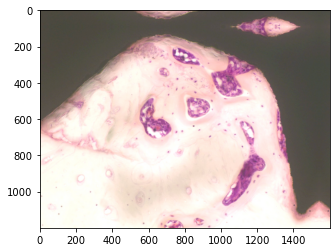

In [20]:
for src in src_image:
    a = Augment(src)
    a.run(
        brightness_value=50,
        fill_mode='reflect',
        width_shift_range=0.2,
        height_shift_range=0.2,
        degree=30,
        vertical_flip=True,
        horizontal_flip=True,
        # crop_size=(200,200)
    )

img = cv2.imread('augmented/src/18-40-02-02 (SLA)_0_0.jpg')
plt.imshow(img[:,:,::-1])

In [21]:
for src, label in zip(src_image, label_image):
    a = Augment(src, label)
    a.run(
        fill_mode='reflect',
        convert_numbers=2,
        crop_numbers=50,
        width_shift_range=0.2,
        height_shift_range=0.2,
        degree=100,
        vertical_flip=True,
        horizontal_flip=True,
        crop_size=(200,200)
    )

[WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'augmented'
[WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'augmented\\src'
[WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'augmented\\label'
0번 째 변환-----------------------
0번 째 변환 중 0번 째 crop
0번 째 변환 중 1번 째 crop
0번 째 변환 중 2번 째 crop
0번 째 변환 중 3번 째 crop
0번 째 변환 중 4번 째 crop
0번 째 변환 중 5번 째 crop
0번 째 변환 중 6번 째 crop
0번 째 변환 중 7번 째 crop
0번 째 변환 중 8번 째 crop
0번 째 변환 중 9번 째 crop
0번 째 변환 중 10번 째 crop
0번 째 변환 중 11번 째 crop
0번 째 변환 중 12번 째 crop
0번 째 변환 중 13번 째 crop
0번 째 변환 중 14번 째 crop
0번 째 변환 중 15번 째 crop
0번 째 변환 중 16번 째 crop
0번 째 변환 중 17번 째 crop
0번 째 변환 중 18번 째 crop
0번 째 변환 중 19번 째 crop
0번 째 변환 중 20번 째 crop
0번 째 변환 중 21번 째 crop
0번 째 변환 중 22번 째 crop
0번 째 변환 중 23번 째 crop
0번 째 변환 중 24번 째 crop
0번 째 변환 중 25번 째 crop
0번 째 변환 중 26번 째 crop
0번 째 변환 중 27번 째 crop
0번 째 변환 중 28번 째 crop
0번 째 변환 중 29번 째 crop
0번 째 변환 중 30번 째 crop
0번 째 변환 중 31번 째 crop
0번 째 변환 중 32번 째 crop
0번 째 변환 중 33번 째 crop
0번 째 변환 중 34번 째 crop
0번 째 변환 중 35번 째 crop
0번 째 변환 중 36번 째 crop
0번 째 변환 중 37번 째 crop
0번 째 변환 중 38번 째 cro